In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Подготовка данных

In [19]:
import requests
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
import random
import math
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [20]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
from tqdm import tqdm
import pandas as pd

class StoryLoader:
    def __init__(self, train_path, test_path, max_train_samples=500, max_test_samples=70):
        self.train_path = train_path
        self.test_path = test_path
        self.max_train_samples = max_train_samples
        self.max_test_samples = max_test_samples
        
    def load_csv_data(self, filepath, max_samples):
        """Загрузка данных из CSV файла"""
        try:
            # Читаем CSV файл
            df = pd.read_csv(filepath)
            
            if 'text' not in df.columns:
                text_column = df.columns[0]
                stories = df[text_column].dropna().tolist()
            else:
                stories = df['text'].dropna().tolist()
            
            # Ограничиваем количество samples
            stories = stories[:max_samples]
            
            print(f"Загружено {len(stories)} историй из {filepath}")
            return stories
            
        except Exception as e:
            print(f"Ошибка при загрузке {filepath}: {e}")
            return []
    
    def load_all_data(self):
        """Загрузка всех данных"""
        train_stories = self.load_csv_data(self.train_path, self.max_train_samples)
        test_stories = self.load_csv_data(self.test_path, self.max_test_samples)
        
        return train_stories, test_stories

    def get_dataset_info(self, train_stories, test_stories):
        if not train_stories or not test_stories:
            return
        print(f"Обучающая выборка: {len(train_stories)} историй")
        print(f"Тестовая выборка: {len(test_stories)} историй")
        print(f"Общий размер: {len(train_stories) + len(test_stories)} историй")
        
        # Берем выборку для статистики
        sample_size = min(100, len(train_stories), len(test_stories))
        train_lengths = [len(story.split()) for story in train_stories[:sample_size]]
        test_lengths = [len(story.split()) for story in test_stories[:sample_size]]
        
        print(f"\nСредняя длина историй (слов):")
        print(f"Обучающие: {sum(train_lengths)/len(train_lengths):.1f}")
        print(f"Тестовые: {sum(test_lengths)/len(test_lengths):.1f}")
        
        print(f"\nПримеры историй:")
        print("\nОбучающая выборка:")
        print(train_stories[0][:200] + "...")
        print("\nТестовая выборка:")
        print(test_stories[0][:200] + "...")

# Токенизация, паддинг, разбиение историй части

In [21]:
class StoryTokenizer:
    def __init__(self, model_name='gpt2'):
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        # Добавляем специальные токены
        self.tokenizer.add_special_tokens({
            'bos_token': '<start>',
            'eos_token': '<end>',
            'pad_token': '<pad>'
        })

    def prepare_story_pairs(self, stories, max_length=256):
        """Разделяет истории на пары"""
        input_sequences = []
        target_sequences = []
        
        for story in tqdm(stories, desc="Подготовка пар"):
            if not story or len(story.strip()) < 10:
                continue
                
            # Токенизируем
            tokens = self.tokenizer.encode(
                story,
                max_length=max_length * 2,
                truncation=True,
                add_special_tokens=False
            )
            
            if len(tokens) < 10:
                continue
                
            split_point = len(tokens) // 2
            
            input_tokens = tokens[:split_point]
            if len(input_tokens) < 5:
                continue
                
            target_tokens = tokens[split_point:]
            if len(target_tokens) < 5:
                continue
                
            # Добавляем BOS и EOS 
            target_tokens = [self.tokenizer.bos_token_id] + target_tokens + [self.tokenizer.eos_token_id]
            
            input_sequences.append(input_tokens)
            target_sequences.append(target_tokens)
        
        print(f"Создано {len(input_sequences)} пар последовательностей")
        return input_sequences, target_sequences

    def pad_sequences(self, sequences, max_length=None, padding_side='right'):
        if max_length is None:
            max_length = max(len(seq) for seq in sequences) if sequences else 64
        
        print(f"Выполнение padding до длины {max_length}")
        
        padded_sequences = []
        attention_masks = []

        for seq in tqdm(sequences, desc="Padding"):
            if len(seq) < max_length:
                padding = [self.tokenizer.pad_token_id] * (max_length - len(seq))
                if padding_side == 'right':
                    padded_seq = seq + padding
                    attention_mask = [1] * len(seq) + [0] * len(padding)
                else:
                    padded_seq = padding + seq
                    attention_mask = [0] * len(padding) + [1] * len(seq)
            else:
                padded_seq = seq[:max_length]
                attention_mask = [1] * max_length
            
            padded_sequences.append(padded_seq)
            attention_masks.append(attention_mask)
        
        return padded_sequences, attention_masks

In [46]:
class StoryDataset(Dataset):
    def __init__(self, input_sequences, target_sequences, input_attention_masks, target_attention_masks):
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences
        self.input_attention_masks = input_attention_masks
        self.target_attention_masks = target_attention_masks
    
    def __len__(self):
        return len(self.input_sequences)
    
    def __getitem__(self, idx):
        return {
            'src': torch.tensor(self.input_sequences[idx], dtype=torch.long),
            'tgt': torch.tensor(self.target_sequences[idx], dtype=torch.long),
            'src_mask': torch.tensor(self.input_attention_masks[idx], dtype=torch.long),
            'tgt_mask': torch.tensor(self.target_attention_masks[idx], dtype=torch.long)
        }

In [50]:
# Загрузка данных
train_path = r"C:\Users\Zver\Desktop\machine_learning\notebook\data\train.csv"
test_path = r"C:\Users\Zver\Desktop\machine_learning\notebook\data\validation.csv"

loader = StoryLoader(
    train_path, 
    test_path, 
    max_train_samples=15000,
    max_test_samples=2500  
)
train_data, test_data = loader.load_all_data()

if train_data and test_data:
    loader.get_dataset_info(train_data, test_data)

tokenizer = StoryTokenizer()

train_inputs, train_targets = tokenizer.prepare_story_pairs(train_data, max_length=128)
test_inputs, test_targets = tokenizer.prepare_story_pairs(test_data, max_length=128)

def safe_max(sequences, default=64):
    if not sequences:
        return default
    return max(len(seq) for seq in sequences)

max_input_len = min(max(safe_max(train_inputs), safe_max(test_inputs)), 128)
max_target_len = min(max(safe_max(train_targets), safe_max(test_targets)), 128)

print(f"Максимальная длина входной последовательности: {max_input_len}")
print(f"Максимальная длина целевой последовательности: {max_target_len}")

# Padding 
train_inputs_padded, train_inputs_attention = tokenizer.pad_sequences(train_inputs, max_length=128)
train_targets_padded, train_targets_attention = tokenizer.pad_sequences(train_targets, max_length=128)
test_inputs_padded, test_inputs_attention = tokenizer.pad_sequences(test_inputs, max_length=128)
test_targets_padded, test_targets_attention = tokenizer.pad_sequences(test_targets, max_length=128)

train_dataset = StoryDataset(
    train_inputs_padded, train_targets_padded,
    train_inputs_attention, train_targets_attention
)
test_dataset = StoryDataset(
    test_inputs_padded, test_targets_padded,
    test_inputs_attention, test_targets_attention
)

# Создаем DataLoader'ы
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Обучающие данные: {len(train_dataset)} примеров")
print(f"Тестовые данные: {len(test_dataset)} примеров")
print(f"Размер батча: {batch_size}")
print(f"Размер vocabulary: {len(tokenizer.tokenizer)}")

Загружено 15000 историй из C:\Users\Zver\Desktop\machine_learning\notebook\data\train.csv
Загружено 2500 историй из C:\Users\Zver\Desktop\machine_learning\notebook\data\validation.csv
Обучающая выборка: 15000 историй
Тестовая выборка: 2500 историй
Общий размер: 17500 историй

Средняя длина историй (слов):
Обучающие: 147.7
Тестовые: 137.9

Примеры историй:

Обучающая выборка:
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on...

Тестовая выборка:
Spot. Spot saw the shiny car and said, "Wow, Kitty, your car is so bright and clean!" Kitty smiled and replied, "Thank you, Spot. I polish it every day."

After playing with the car, Kitty and Spot fe...


Подготовка пар: 100%|███████████████████████████████████████████████████████████| 15000/15000 [00:16<00:00, 929.94it/s]


Создано 15000 пар последовательностей


Подготовка пар: 100%|█████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 960.66it/s]


Создано 2500 пар последовательностей
Максимальная длина входной последовательности: 128
Максимальная длина целевой последовательности: 128
Выполнение padding до длины 128


Padding: 100%|███████████████████████████████████████████████████████████████| 15000/15000 [00:00<00:00, 153246.44it/s]


Выполнение padding до длины 128


Padding: 100%|███████████████████████████████████████████████████████████████| 15000/15000 [00:00<00:00, 156797.19it/s]


Выполнение padding до длины 128


Padding: 100%|█████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 125472.78it/s]


Выполнение padding до длины 128


Padding: 100%|█████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 147753.35it/s]

Обучающие данные: 15000 примеров
Тестовые данные: 2500 примеров
Размер батча: 8
Размер vocabulary: 50260


In [53]:
if len(train_dataset) > 0:
    first_batch = next(iter(train_loader))

    print(f"\nРазмеры в батче:")
    for key, value in first_batch.items():
        print(f"{key}: {value.shape}")

    print(f"\nПример входной последовательности:")
    input_text = tokenizer.tokenizer.decode(
        first_batch['src'][0], 
        skip_special_tokens=True
    )
    print(input_text[:200] + "...")

    print(f"\nПример целевой последовательности:")
    target_text = tokenizer.tokenizer.decode(
        first_batch['tgt'][0], 
        skip_special_tokens=True
    )
    print(target_text[:200] + "...")
else:
    print("Нет данных для обучения")


Размеры в батче:
src: torch.Size([8, 128])
tgt: torch.Size([8, 128])
src_mask: torch.Size([8, 128])
tgt_mask: torch.Size([8, 128])

Пример входной последовательности:
Mummy was taking Mary to the park to play. When they arrived at the bus stop, a big, empty bus was waiting. Mary was so excited she jumped up and down!

When Mummy paid for the tickets, she told Mary ...

Пример целевой последовательности:
 and smaller.

The shrinking bus was soon the size of a toy! Mary was so surprised she had to laugh!

Mummy picked up the tiny bus and said, "Look, Mary, we can take it with us to the park. Isn't that...


In [54]:
data_config = {
    'train_loader': train_loader,
    'test_loader': test_loader,
    'tokenizer': tokenizer,
    'vocab_size': len(tokenizer.tokenizer),
    'train_dataset': train_dataset,
    'test_dataset': test_dataset
}


# Архитектура Multi-Head Attention

In [55]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, 'd_model must be divisible by num_heads'

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    

    def scaled_dot_product_attention(self, Q,K,V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask==0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
    

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output=self.scaled_dot_product_attention(Q,K,V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output
    

# Архитектура Position-wise Feed-Forward Networks

In [56]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x))) 


# Архитектура Positional Encoding

In [57]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2]=torch.sin(position*div_term)
        pe[:, 1::2]=torch.cos(position*div_term)

        self.register_buffer('pe', pe.unsqueeze(0))
                            

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
                        
                        
    

# Архитектура Encoder слоя

In [58]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x,x,x,mask)
        x = self.norm1(x+self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
        

# Архитектура Decoder слоя

In [59]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

# Модель Transformer

In [60]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

# Обучение

In [61]:
# Инициализация модели
vocab_size = data_config['vocab_size']
transformer = Transformer(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=128,
    num_heads=4,
    num_layers=2,
    d_ff=256,
    max_seq_length=128,
    dropout=0.3
)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.tokenizer.pad_token_id)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)

In [62]:
# Перплексия
def calculate_perplexity(loss):
    return math.exp(loss)

def generate_text(model, tokenizer, prompt, max_length=50, temperature=0.8, top_k=50):
    model.eval()
    
    # Кодируем промпт
    input_ids = tokenizer.tokenizer.encode(prompt, add_special_tokens=False)
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    
    generated = input_ids.copy()
    
    with torch.no_grad():
        # Получаем выход encoder один раз
        src_mask = (input_tensor != 0).unsqueeze(1).unsqueeze(2)
        enc_output = model.encoder_embedding(input_tensor)
        enc_output = model.positional_encoding(enc_output)
        
        for enc_layer in model.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)
        
        # Генерируем токен за токеном
        for _ in range(max_length):
            target_tensor = torch.tensor([generated], dtype=torch.long).to(device)
            
            # Forward через decoder
            tgt_embedded = model.decoder_embedding(target_tensor)
            tgt_embedded = model.positional_encoding(tgt_embedded)
            
            dec_output = tgt_embedded
            for dec_layer in model.decoder_layers:
                _, tgt_mask = model.generate_mask(target_tensor, target_tensor)
                dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)
            
            logits = model.fc(dec_output)
            
            # Берем последний токен + применяем top-k
            next_token_logits = logits[0, -1, :] / temperature
            
            # Top-k filtering
            indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
            next_token_logits[indices_to_remove] = -float('Inf')
            
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1).item()
            
            generated.append(next_token)
            
            # Стоп-условия
            if (next_token == tokenizer.tokenizer.eos_token_id or 
                len(generated) >= max_length):
                break
    
    return tokenizer.tokenizer.decode(generated, skip_special_tokens=True)

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = transformer.to(device)

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

transformer.train()

for epoch in range(10):
    transformer.train()
    total_train_loss = 0
    train_batches = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/10 [Train]')
    for batch in progress_bar:
        src_data = batch['src'].to(device)
        tgt_data = batch['tgt'].to(device)
        
        optimizer.zero_grad()
        output = transformer(src_data, tgt_data[:, :-1])
        loss = criterion(
            output.contiguous().view(-1, vocab_size), 
            tgt_data[:, 1:].contiguous().view(-1)
        )
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        train_batches += 1
        
        # Обновляем прогресс-бар
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = total_train_loss / train_batches
    train_losses.append(avg_train_loss)
    train_perplexity = calculate_perplexity(avg_train_loss)
    train_perplexities.append(train_perplexity)
    
    # Валидация
    transformer.eval()
    total_val_loss = 0
    val_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/10 [Val]'):
            src_data = batch['src'].to(device)
            tgt_data = batch['tgt'].to(device)
            
            output = transformer(src_data, tgt_data[:, :-1])
            loss = criterion(
                output.contiguous().view(-1, vocab_size), 
                tgt_data[:, 1:].contiguous().view(-1)
            )
            total_val_loss += loss.item()
            val_batches += 1
    
    avg_val_loss = total_val_loss / val_batches
    val_losses.append(avg_val_loss)
    val_perplexity = calculate_perplexity(avg_val_loss)
    val_perplexities.append(val_perplexity)
    
    print(f'Epoch: {epoch+1:02d}')
    print(f'Train Loss: {avg_train_loss:.4f} | Train PPL: {train_perplexity:.2f}')
    print(f'Val Loss:   {avg_val_loss:.4f} | Val PPL:   {val_perplexity:.2f}')


Epoch 1/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.49it/s]


Epoch: 01
Train Loss: 6.1560 | Train PPL: 471.52
Val Loss:   6.0046 | Val PPL:   405.28


Epoch 2/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.35it/s]


Epoch: 02
Train Loss: 5.9971 | Train PPL: 402.27
Val Loss:   5.8898 | Val PPL:   361.32


Epoch 3/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.46it/s]


Epoch: 03
Train Loss: 5.9240 | Train PPL: 373.89
Val Loss:   5.8186 | Val PPL:   336.50


Epoch 4/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.79it/s]


Epoch: 04
Train Loss: 5.8479 | Train PPL: 346.51
Val Loss:   5.7239 | Val PPL:   306.09


Epoch 5/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 10.95it/s]


Epoch: 05
Train Loss: 5.7604 | Train PPL: 317.48
Val Loss:   5.6315 | Val PPL:   279.09


Epoch 6/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:31<00:00,  9.84it/s]


Epoch: 06
Train Loss: 5.6814 | Train PPL: 293.37
Val Loss:   5.5302 | Val PPL:   252.19


Epoch 7/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.28it/s]


Epoch: 07
Train Loss: 5.5830 | Train PPL: 265.86
Val Loss:   5.4037 | Val PPL:   222.22


Epoch 8/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.41it/s]


Epoch: 08
Train Loss: 5.4652 | Train PPL: 236.33
Val Loss:   5.2733 | Val PPL:   195.06


Epoch 9/10 [Val]: 100%|██████████████████████████████████████████████████████████████| 313/313 [00:29<00:00, 10.57it/s]


Epoch: 09
Train Loss: 5.3433 | Train PPL: 209.20
Val Loss:   5.1595 | Val PPL:   174.07


Epoch 10/10 [Val]: 100%|█████████████████████████████████████████████████████████████| 313/313 [00:32<00:00,  9.66it/s]

Epoch: 10
Train Loss: 5.2403 | Train PPL: 188.74
Val Loss:   5.0406 | Val PPL:   154.56


In [67]:
test_prompts = ["Once upon a time"]

print("Разные стратегии генерации:")
for prompt in test_prompts:
    print(f"\nПромпт: '{prompt}'")
    
    # Консервативная 
    conservative = generate_text(transformer, tokenizer, prompt, 
                                temperature=0.7, top_k=30, max_length=30)
    print(f"Консервативная: '{conservative}'")
    
    # Креативная
    creative = generate_text(transformer, tokenizer, prompt, 
                            temperature=1.2, top_k=100, max_length=30)
    print(f"Креативная: '{creative}'")

Разные стратегии генерации:

Промпт: 'Once upon a time'
Консервативная: 'Once upon a time and started, she saw the little girl said, Lily was still had a bird was very happy to be scared was so happy.'
Креативная: 'Once upon a time came to help the park, when very happy to a a way and his get. She looked was proud bird. From that they'


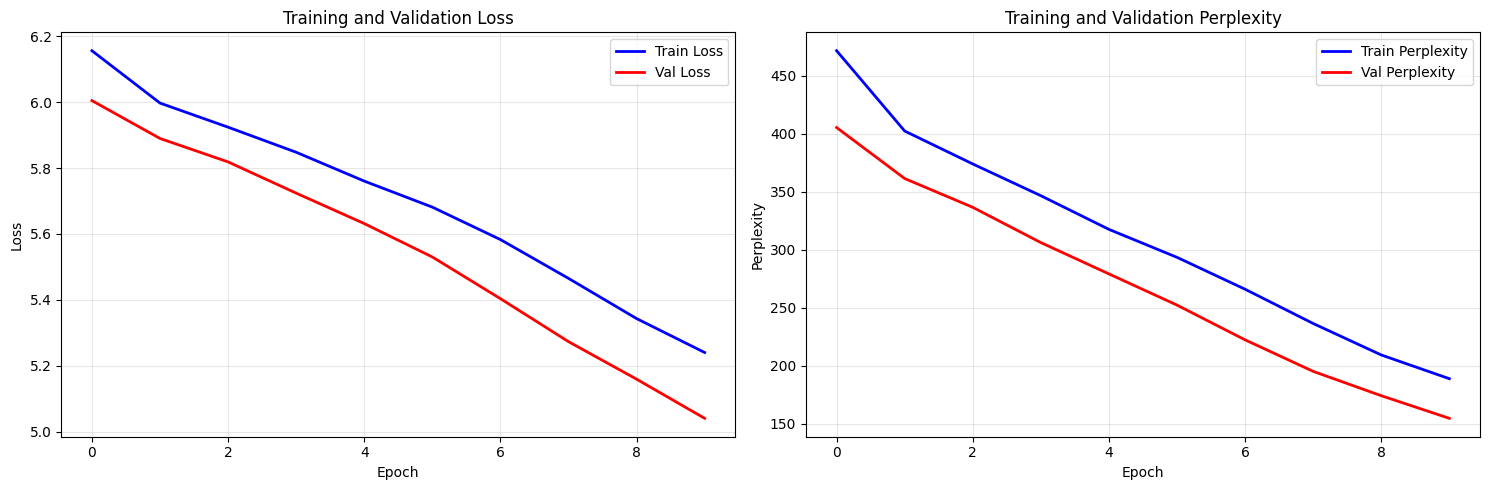


ОЦЕНКА МОДЕЛИ
Final Train Loss: 5.2403
Final Val Loss: 5.0406
Final Train Perplexity: 188.74
Final Val Perplexity: 154.56


In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# График loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Val Loss', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# График перплексии
plt.subplot(1, 2, 2)
plt.plot(train_perplexities, label='Train Perplexity', color='blue', linewidth=2)
plt.plot(val_perplexities, label='Val Perplexity', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Финальная оценка
print("\n" + "="*50)
print("ОЦЕНКА МОДЕЛИ")
print("="*50)
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Perplexity: {train_perplexities[-1]:.2f}")
print(f"Final Val Perplexity: {val_perplexities[-1]:.2f}")